# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [2]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [3]:
import decoupler as dc

In [4]:
dc.__version__

'1.6.2'

In [5]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [ ]:
adata = sc.read_h5ad(input_path) 
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [ ]:
adata

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [ ]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [ ]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 02.CELL TPYE RE-CLASIFICATION 

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
adata.obs.cell_type_major.value_counts()

In [ ]:
cells_of_interest=['alveolar macrophage', 'neutrophil',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
set(subset_adata.obs.cell_type_major)

In [ ]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
subset_adata

In [ ]:
adata

Number of cells: 
- Original adata 1283972
- Adata after filtering for disease, sex, origin, tumor stage  887157
- Subset adata for cells of interest and renaming 638804

- In 00_get_chromosome I have retrieved the information for the chromosome and I append to subset_adata.

- Compute DEG (male vs female)
  Separate into 3 dataframes: autosomal_adata, xchrom_adata, ychrom_adata
- Create bar plot to compare Number of DEG in TUMOR vs NORMAL 

### 03.Get X, Y and autosomal genes

In [ ]:
nsclc_chrom = nsclc_chrom.rename(columns={"ensembl_gene_id":"gene_id"})
nsclc_chrom = nsclc_chrom.iloc[:,1:]
nsclc_chrom = nsclc_chrom.set_index("gene_id")
nsclc_chrom["gene_id"] = nsclc_chrom.index

In [ ]:
subset_adata.var["gene_id"] = subset_adata.var_names 
subset_adata_var_chrom =pd.concat([subset_adata.var, nsclc_chrom], axis = 1)
subset_adata.var = subset_adata_var_chrom

In [ ]:
subset_adata.var["chromosome_name"]  = subset_adata.var["chromosome_name"].astype(str)

In [ ]:
subset_indices = subset_adata.var['chromosome_name'] == 'X'

# Subset adata to keep only the genes with chromosome 'X'
xchrom_adata = subset_adata[:, subset_indices]

In [ ]:
subset_indices = subset_adata.var['chromosome_name'] == 'Y'

# Subset adata to keep only the genes with chromosome 'Y'
ychrom_adata = subset_adata[:, subset_indices]

In [ ]:
subset_indices = (subset_adata.var['chromosome_name'] != 'Y') &  (subset_adata.var['chromosome_name'] != 'X') 

# Subset adata to keep only the genes with chromosome 'Y'
autosomal_adata = subset_adata[:, subset_indices]

In [ ]:
#xchrom_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/xchrom_adata_var.csv")
#ychrom_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/ychrom_adata_var.csv")
#autosomal_adata.var.to_csv(f"{path}/out/007_re_analysis/tables/input/autosomal_adata_var.csv")

In [42]:
xchrom_adata.shape

(638804, 618)

In [43]:
ychrom_adata.shape

(638804, 16)

In [41]:
autosomal_adata.shape

(638804, 17177)

### 04.Compute pseudobulk

In [45]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    subset_adata,
    sample_col='sample',
    groups_col='donor_id',
    layer='count',
    min_cells=0,
    min_counts=0
)

In [81]:
pdata_var_concat =pd.concat([pdata.var, nsclc_chrom],axis=1)

In [82]:
pdata_var_concat

,ensembl_gene_id_version,chromosome_name,start_position,end_position,gene_id
gene_id,,,,,
ENSG00000000419,ENSG00000000419.14,20,50934867.0,50959140.0,ENSG00000000419
ENSG00000000457,ENSG00000000457.14,1,169849631.0,169894267.0,ENSG00000000457
ENSG00000000460,ENSG00000000460.17,1,169662007.0,169854080.0,ENSG00000000460
ENSG00000000938,ENSG00000000938.13,1,27612064.0,27635185.0,ENSG00000000938
ENSG00000000971,ENSG00000000971.17,1,196651754.0,196752476.0,ENSG00000000971
...,...,...,...,...,...
ENSG00000286522,ENSG00000286522.2,6,26031589.0,26032099.0,ENSG00000286522
ENSG00000287080,ENSG00000287080.2,6,26045384.0,26045869.0,ENSG00000287080
ENSG00000287151,ENSG00000287151.1,2,131647990.0,131767404.0,ENSG00000287151


In [53]:
pdata.obs["age"] = pdata.obs["age"].astype("float64")
pdata.obs["is_primary_data"] = pdata.obs["is_primary_data"].astype(bool)


In [60]:
#pdata.write_h5ad(f"{path}/out/007_re_analysis/tables/pdata.h5ad")
pdata = sc.read_h5ad(f"{path}/out/007_re_analysis/tables/input/pdata.h5ad")

In [61]:
pdata

AnnData object with n_obs × n_vars = 289 × 9304
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'

In [8]:
dc.__version__

'1.6.2'

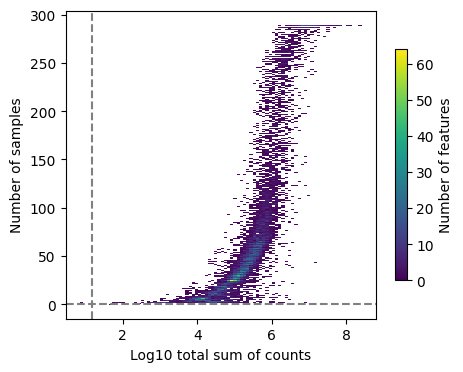

In [62]:
dc.plot_filter_by_expr(pdata, group='sample', min_count=10, min_total_count=15)

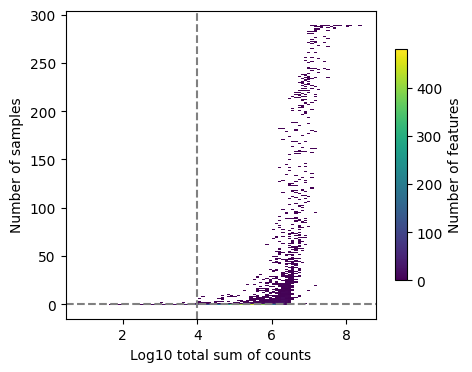

In [64]:
dc.plot_filter_by_expr(pdata, group='sample', large_n=100,min_prop=0.9, min_count=5000, min_total_count=10000)

In [65]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group='sample', min_count=5000, min_total_count=10000)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 289 × 1619
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'

In [66]:
pdata.layers["counts"] = pdata.X

In [67]:
scales_counts = sc.pp.normalize_total(pdata, target_sum=None, inplace=False)
# log1p transform
pdata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [68]:
pdata

AnnData object with n_obs × n_vars = 289 × 1619
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    layers: 'counts', 'log1p_norm'

In [69]:
### Samplesheet
samplesheet = pdata.obs.copy()
samplesheet["sample"]=samplesheet.index
samplesheet.reset_index(inplace=True)

In [70]:
samplesheet.to_csv(f"{path}/out/007_re_analysis/tables/input/samplesheet.csv", index=False)
samplesheet.to_csv(f"{path}/out/007_re_analysis/tables/input/samplesheet.tsv", index=False, sep = "\t")

In [71]:
bulk_df = pdata.to_df().T

In [72]:
### Raw counts
bulk_df = pdata.to_df().T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")

/tmp/ipykernel_2402300/3249437527.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")


In [73]:
pdata.to_df()

gene_id,ENSG00000000938,ENSG00000002549,ENSG00000002586,ENSG00000003056,ENSG00000003402,ENSG00000003436,ENSG00000004059,ENSG00000004534,ENSG00000004799,ENSG00000005022,...,ENSG00000271383,ENSG00000271503,ENSG00000272398,ENSG00000275302,ENSG00000275385,ENSG00000276070,ENSG00000277443,ENSG00000277632,ENSG00000277734,ENSG00000277791
Goveia_Carmeliet_2020_patient_40_normal_adjacent_Goveia_Carmeliet_2020_patient_40,2622.0,1923.0,2397.0,1761.0,637.0,0.0,636.0,0.0,1995.0,4049.0,...,0.0,0.0,0.0,1498.0,32481.0,0.0,0.0,0.0,0.0,3035.0
Goveia_Carmeliet_2020_patient_40_tumor_primary_Goveia_Carmeliet_2020_patient_40,628.0,796.0,933.0,623.0,318.0,0.0,357.0,0.0,1428.0,1998.0,...,0.0,0.0,0.0,1496.0,12034.0,0.0,0.0,0.0,0.0,1420.0
Goveia_Carmeliet_2020_patient_41_normal_adjacent_Goveia_Carmeliet_2020_patient_41,0.0,0.0,1845.0,0.0,0.0,0.0,0.0,0.0,0.0,2049.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2186.0
Goveia_Carmeliet_2020_patient_41_tumor_primary_Goveia_Carmeliet_2020_patient_41,0.0,0.0,2330.0,0.0,0.0,0.0,0.0,0.0,0.0,2581.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1414.0
Goveia_Carmeliet_2020_patient_42_normal_adjacent_Goveia_Carmeliet_2020_patient_42,0.0,1936.0,6275.0,2051.0,872.0,0.0,0.0,0.0,3179.0,4838.0,...,0.0,0.0,0.0,4240.0,61148.0,0.0,546.0,2688.0,0.0,4163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zilionis_Klein_2019_p5t2_Zilionis_Klein_2019_patient_5,0.0,0.0,0.0,0.0,687.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zilionis_Klein_2019_p6t1_Zilionis_Klein_2019_patient_6,0.0,0.0,852.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,...,0.0,660.0,0.0,0.0,0.0,0.0,0.0,0.0,1074.0,0.0
Zilionis_Klein_2019_p6t2_Zilionis_Klein_2019_patient_6,0.0,0.0,789.0,0.0,0.0,0.0,0.0,0.0,0.0,414.0,...,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,851.0,0.0
Zilionis_Klein_2019_p7t1_Zilionis_Klein_2019_patient_7,0.0,0.0,518.0,0.0,824.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14356.0,0.0,1051.0,0.0,0.0,0.0


In [74]:
bulk_df.to_csv(f"{path}/out/007_re_analysis/tables/input/counts.csv")    

In [75]:
### log1p_norm counts
pdata_log1p_norm = pd.DataFrame(pdata.layers["log1p_norm"], 
    pdata.to_df().index, 
    pdata.to_df().columns)
bulk_df = pdata_log1p_norm.T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
bulk_df.to_csv(f"{path}/out/007_re_analysis/tables/input/log1p_norm_counts.csv")    

/tmp/ipykernel_2402300/1660016733.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")


### 0.4 Create counts and samplesheet independent for tumor and normal for DESEQ2 

In [46]:
pdata_normal = pdata[pdata.obs["origin"]=="normal_adjacent"]
pdata_tumor = pdata[pdata.obs["origin"]=="tumor_primary"]

In [47]:
pdata_normal

View of AnnData object with n_obs × n_vars = 111 × 9304
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    layers: 'counts', 'log1p_norm'

In [48]:
pdata_list = [pdata_normal,pdata_tumor]
pdata_list_name = ["normal","tumor"]

for index, dataframe in enumerate(pdata_list):
    print(pdata_list_name[index])
    # Perform the operations
    samplesheet = dataframe.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{path}/out/007_re_analysis/tables/input/samplesheet_{pdata_list_name[index]}.csv", index=False)
    samplesheet.to_csv(f"{path}/out/007_re_analysis/tables/input/samplesheet_{pdata_list_name[index]}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = dataframe.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/out/007_re_analysis/tables/input/counts_{pdata_list_name[index]}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(dataframe.layers["log1p_norm"], 
        dataframe.to_df().index, 
        dataframe.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/out/007_re_analysis/tables/input/log1p_norm_counts_{pdata_list_name[index]}.csv")    

normal


/tmp/ipykernel_8900/925062667.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
/tmp/ipykernel_8900/925062667.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")


tumor


/tmp/ipykernel_8900/925062667.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
/tmp/ipykernel_8900/925062667.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
